In [1]:
import pandas as pd
import numpy as np

cols= ['Q{}'.format(idx) for idx in range(1,11)]
data= pd.read_csv('ouirt.dat', sep= ' ', names= cols)
data.head(2)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
NaN,0,1,1,1,1,1,1,1,1,0
NaN,0,1,0,0,1,0,1,0,0,0


In [2]:
data= pd.DataFrame(data.values, columns=cols)
data.describe()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.150000,0.268000,0.318000,0.296000,0.438000,0.314000,0.412000,0.334000,0.318000,0.070000
std,0.357429,0.443361,0.466166,0.456948,0.496638,0.464581,0.492688,0.472112,0.466166,0.255403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


*  Truncating Question items to 3

In [3]:
rel_items = cols[:3]#Q1,Q2,Q3
df = data[rel_items]
df.head(3)

,Q1,Q2,Q3
0,0,1,1
1,0,1,0
2,0,0,0


In [4]:
df_cols = ['user','questions', 'response']#final dataframe cols

In [5]:
#pd.DataFrame({'user': list(range(df.shape[0]*3)), 
# 'questions':['Q1']*500+ ['Q2']*500+ ['Q3']*500,'response':pd.concat([df[feat_cols[0]],
# df[feat_cols[1]], df[feat_cols[2]]]).values})

In [6]:
from collections import defaultdict
di = defaultdict(dict)
for idx in rel_items:
    di[idx].update(zip(range(df.shape[0]), df[idx].values))#makes format {'Q1':{user:responses,1:0,2:0,. . .,}}

* Following dataframe contains-- user id, questions id, corresponding response value

In [7]:
df_list= list()
for ques, user_resp in list(zip(di.keys(), di.values())):
    df_list.append({'user':list(user_resp.keys()), 'questions':[ques]*df.shape[0], 'response':list(user_resp.values())})

df1=pd.DataFrame(df_list[0])
df2=pd.DataFrame(df_list[1])
df3=pd.DataFrame(df_list[2])
df_new= pd.concat([df1,df2,df3], ignore_index=True)
df_new = df_new.loc[np.random.randint(0,1499, size=1500)]#shuffling data
df_new

,user,questions,response
50,50,Q1,0
1120,120,Q3,1
286,286,Q1,0
683,183,Q2,0
631,131,Q2,0
...,...,...,...
1181,181,Q3,1
362,362,Q1,0
1209,209,Q3,0
1060,60,Q3,0


### Defining Keras equivalent model

In [8]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Activation
from keras import metrics
from keras.utils import to_categorical

Using TensorFlow backend.
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kev/Desktop/pyvirtual2/lib/pytho

In [9]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(df_new[df_cols[:-1]], df_new[df_cols[-1]], test_size=0.05)

In [10]:
x_train_user = to_categorical(xtrain['user'])#contains the one-hot encoded user data
x_train_questions = pd.get_dummies(xtrain['questions']).values#contains the one-hot encoded questions

y_train= ytrain.values
print('shape of x_train_user:', x_train_user.shape,'\nshape of x_train_questions:', x_train_questions.shape,
      '\nshape of y_train:',y_train.shape)

shape of x_train_user: (1425, 500) 
shape of x_train_questions: (1425, 3) 
shape of y_train: (1425,)


### 1 PL IRT model:
* t_i= Degree of latent trait of i-th student
* b_j= difficulty_level of j-th question
* P(i,j) = Prob of i-th student, correctly scoring on j-th item.

`P{i=1,j} = Sigmoid[(t_i- b_j)]`

In [11]:
user_input_layer = Input(shape=(x_train_user.shape[1],))#top half of input taking input feature 1
quest_input_layer = Input(shape=(x_train_questions.shape[1],))#bottom half of input taking input feature 2

latent_trait = Dense(1, use_bias=False)(user_input_layer)
difficulty_level = Dense(1, use_bias=False)(quest_input_layer)

latent_difficulty_subtract = keras.layers.Subtract()([latent_trait, difficulty_level])

# set the output layer weight to 1, bias to 0 and make it non-trainable
prediction_output = Dense(1, activation='sigmoid',trainable=False,use_bias=False,kernel_initializer=keras.initializers.Ones())(latent_difficulty_subtract)


model1 = Model(inputs=[user_input_layer, quest_input_layer], outputs= prediction_output)

model1.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            500         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            3           input_2[0][0]                    
____________________________________________________________________________________________

In [13]:
history= model1.fit(x=[x_train_user,x_train_questions], y=y_train, epochs=8, verbose=1, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 1140 samples, validate on 285 samples
Epoch 1/8
1140/1140 [==============================] - 0s 391us/step - loss: 0.6907 - mae: 0.4752 - accuracy: 0.5289 - val_loss: 0.6833 - val_mae: 0.4746 - val_accuracy: 0.5333
Epoch 2/8
1140/1140 [==============================] - 0s 39us/step - loss: 0.6823 - mae: 0.4717 - accuracy: 0.5289 - val_loss: 0.6734 - val_mae: 0.4703 - val_accuracy: 0.5333
Epoch 3/8
1140/1140 [==============================] - 0s 40us/step - loss: 0.6744 - mae: 0.4682 - accuracy: 0.5289 - val_loss: 0.6640 - val_mae: 0.4661 - val_accuracy: 0.5333
Epoch 4/8
1140/1140 [==============================] - 0s 38us/step - loss: 0.6669 - mae: 0.4648 - accuracy: 0.5289 - val_loss: 0.6553 - val_mae: 0.4621 - val_accuracy: 0.5333
Epoch 5/8
1140/1140 [==============================] - 0s 48us/step - loss: 0.6599 - mae: 0.4615 - accuracy: 0.5289 - val_loss: 0.6469 - val_mae: 0.4581 - val_accuracy: 0.5333
Epoch 6/8
1140/1140 [===

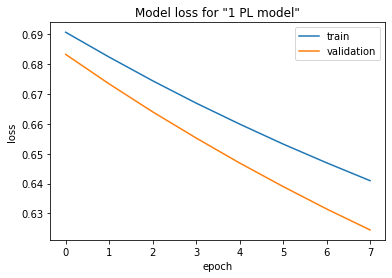

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for "1 PL model"')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'], loc= 'upper right')
plt.show()

### 2 PL IRT model

* t_i= Degree of latent trait of i-th student
* b_j= difficulty_level of j-th question
* a_j= discrimination parameter of j-th question
* P(i,j) = Prob of i-th student, correctly scoring on j-th item


`P{i=1,j} = Sigmoid[a_j(t_i - b_j)]`

In [16]:
user_input_layer = Input(shape=(x_train_user.shape[1],))#top half of input taking input feature 1
quest_input_layer = Input(shape=(x_train_questions.shape[1],))#bottom half of input taking input feature 2

latent_trait = Dense(1, use_bias=False)(user_input_layer)

difficulty_level = Dense(1, use_bias=False)(quest_input_layer)
discrimination_param = Dense(1, use_bias=False)(quest_input_layer)

latent_difficulty_subtract = keras.layers.Subtract()([latent_trait, difficulty_level])

disc_param_interaction = keras.layers.Multiply()([latent_difficulty_subtract, 
                                                    discrimination_param])


#prediction_output = Dense(1, activation='sigmoid')(disc_param_interaction)
# last layer is dummy. it is not trainable, weight =1, bias = 0
prediction_output = Dense(1, activation='sigmoid',trainable=False,use_bias=False,kernel_initializer=keras.initializers.Ones())(disc_param_interaction)
model2 = Model(inputs=[user_input_layer, quest_input_layer], outputs= prediction_output)

model2.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])

In [17]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1)            500         input_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 1)            3           input_4[0][0]                    
____________________________________________________________________________________________

In [18]:
history= model2.fit(x=[x_train_user,x_train_questions], y=y_train, epochs=8, verbose=1, validation_split=0.2)

Train on 1140 samples, validate on 285 samples
Epoch 1/8
1140/1140 [==============================] - 0s 154us/step - loss: 0.6409 - mae: 0.4568 - accuracy: 0.5289 - val_loss: 0.6214 - val_mae: 0.4487 - val_accuracy: 0.5333
Epoch 2/8
1140/1140 [==============================] - 0s 39us/step - loss: 0.6358 - mae: 0.4538 - accuracy: 0.5816 - val_loss: 0.6153 - val_mae: 0.4454 - val_accuracy: 0.8070
Epoch 3/8
1140/1140 [==============================] - 0s 41us/step - loss: 0.6310 - mae: 0.4510 - accuracy: 0.7632 - val_loss: 0.6095 - val_mae: 0.4421 - val_accuracy: 0.8070
Epoch 4/8
1140/1140 [==============================] - 0s 39us/step - loss: 0.6264 - mae: 0.4483 - accuracy: 0.7632 - val_loss: 0.6040 - val_mae: 0.4389 - val_accuracy: 0.8070
Epoch 5/8
1140/1140 [==============================] - 0s 39us/step - loss: 0.6219 - mae: 0.4456 - accuracy: 0.7632 - val_loss: 0.5986 - val_mae: 0.4357 - val_accuracy: 0.8070
Epoch 6/8
1140/1140 [==============================] - 0s 39us/step - lo

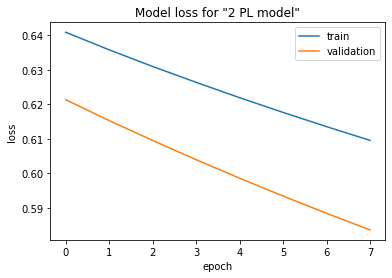

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for "2 PL model"')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'], loc= 'upper right')
plt.show()

### 3 PL IRT model
* t_i= Degree of latent trait of i-th student
* b_j= difficulty_level of j-th question
* a_j= discrimination parameter of j-th question
* c_j= pseudo guessing parameter of j-th question
* P(i,j) = Prob of i-th student, correctly scoring on j-th item.

`P{i=1,j} = Sigmoid[c_j+ a_j(1-c_j)(t_i - b_j)]`

In [20]:
from keras import backend as K
from keras.layers import Lambda

In [21]:
#for the purpose of Lambda layer
def ops_func(x, op='add'):
    if op=='add':
        return K.constant(value=np.array([x[0]])) + x[1]
    if op=='subtract':
        return K.constant(value=np.array([x[0]])) - x[1]
    if op=='multiply':
        return K.constant(value=np.array([x[0]]))* x[1]

In [22]:
user_input_layer = Input(shape=(x_train_user.shape[1],))#top half of input
quest_input_layer = Input(shape=(x_train_questions.shape[1],))#bottom half of input

latent_trait = Dense(1, use_bias=False)(user_input_layer)

difficulty_level = Dense(1, use_bias=False)(quest_input_layer)
discrimination_param = Dense(1, use_bias=False)(quest_input_layer)
guess_param = Dense(1, use_bias=False)(quest_input_layer)

latent_difficulty_subtract = keras.layers.Subtract()([latent_trait, difficulty_level])

disc_param_interaction = keras.layers.Multiply()([latent_difficulty_subtract, 
                                                    discrimination_param])

#guess_param_interaction= Lambda(lambda x: K.constant(value=np.array([-1]))*x)(guess_param)
guess_param_interaction= Lambda(lambda x: K.constant(value=np.array([1])) - x)(guess_param)
guess_param_interaction= keras.layers.Multiply()([disc_param_interaction, 
                                                guess_param_interaction])

guess_param_interaction= keras.layers.Add()([guess_param, guess_param_interaction])


#prediction_output = Dense(1, activation='sigmoid')(guess_param_interaction)
# last layer is dummy. it is not trainable, weight =1, bias = 0
prediction_output = Dense(1, activation='sigmoid',trainable=False,use_bias=False,kernel_initializer=keras.initializers.Ones())(guess_param_interaction)


model3 = Model(inputs=[user_input_layer, quest_input_layer], outputs= prediction_output)
model3.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])

In [23]:
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 1)            500         input_5[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1)            3           input_6[0][0]                    
____________________________________________________________________________________________

In [24]:
history= model3.fit(x=[x_train_user,x_train_questions], y=y_train, epochs=8, verbose=1, validation_split=0.2)

Train on 1140 samples, validate on 285 samples
Epoch 1/8
1140/1140 [==============================] - 0s 187us/step - loss: 0.7346 - mae: 0.4838 - accuracy: 0.6079 - val_loss: 0.7596 - val_mae: 0.4959 - val_accuracy: 0.5860
Epoch 2/8
1140/1140 [==============================] - 0s 42us/step - loss: 0.7306 - mae: 0.4807 - accuracy: 0.6079 - val_loss: 0.7550 - val_mae: 0.4924 - val_accuracy: 0.5860
Epoch 3/8
1140/1140 [==============================] - 0s 44us/step - loss: 0.7269 - mae: 0.4780 - accuracy: 0.6079 - val_loss: 0.7509 - val_mae: 0.4892 - val_accuracy: 0.5860
Epoch 4/8
1140/1140 [==============================] - 0s 47us/step - loss: 0.7236 - mae: 0.4752 - accuracy: 0.6079 - val_loss: 0.7472 - val_mae: 0.4862 - val_accuracy: 0.5860
Epoch 5/8
1140/1140 [==============================] - 0s 56us/step - loss: 0.7207 - mae: 0.4728 - accuracy: 0.6079 - val_loss: 0.7439 - val_mae: 0.4833 - val_accuracy: 0.5860
Epoch 6/8
1140/1140 [==============================] - 0s 62us/step - lo

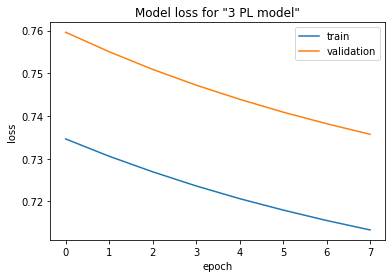

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for "3 PL model"')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'], loc= 'upper right')
plt.show()